In [ ]:
import concurrent.futures
import pandas as pd 
import numpy as np
import importlib

import pysam

import matplotlib.pyplot as plt
from upsetplot import UpSet

import parse_vcf_files
importlib.reload(parse_vcf_files)

import parse_fasta
importlib.reload(parse_fasta)

import exact_motif_counts
importlib.reload(exact_motif_counts)

import compare_with_asm
importlib.reload(compare_with_asm)

import plots
importlib.reload(plots)

import trio_analysis
importlib.reload(trio_analysis)

import population_analysis
importlib.reload(population_analysis)


<module 'population_analysis' from '/confidential/tGenVar/vntr/output_maryam/tools/tandemtwister-vis-maryam/scripts/population_analysis.py'>

In [19]:
!pip3 install seaborn
!pip3 install upsetplot
!pip3 install matplotlib
!pip3 install pandas
!pip3 install numpy
!pip3 install pysam
!pip3 install pyfaidx
!pip3 install pybedtools
!pip3 install python-Levenshtein
!pip3 install pandarallel
!pip3 install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 39.3 MB/s eta 0:00:00


### Transform tandemTwister/vamos  format of input regions to TRGT format 

In [ ]:
## df_TRGT_pathogenic = pd.read_csv("/confidential/tGenVar/Lion/TandemTwist/pathogenic_TR_TRGT.tsv", sep="\t")
df_TRGT_pathogenic = pd.read_csv("/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/input_folder/regions/pathogenic_TR_TRGT.tsv", sep="\t")

df_TRGT_pathogenic.columns = ['chrom', 'start', 'end', 'ID']

#chr16   66490398        66490467        ID=BEAN1;MOTIFS=TGGAA,TAAAA;STRUC=<BEAN1>
# parse the ID field and split it into ID, MOTIFS
df_TRGT_pathogenic['name'] = df_TRGT_pathogenic['ID'].str.split(';').str[0].str.split('=').str[1]
# get the motifs from MOTIFS field
df_TRGT_pathogenic['MOTIFS'] = df_TRGT_pathogenic['ID'].str.split(';').str[1].str.split('=').str[1]
df_TRGT_pathogenic.drop('ID', axis=1, inplace=True)
# order the columns, chrom, start, end, MOTIFS, name
## df_TRGT_pathogenic.to_csv("/confidential/tGenVar/Lion/TandemTwist/pathogenic_TRs.bed", sep="\t", index=False, header=False)
df_TRGT_pathogenic.to_csv("/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/input_folder/regions/pathogenic_TRs.tsv", sep="\t", index=False, header=False)

# Parsing the vcf file of cut asm sequence
for HG002 (NA24385 sample in hgsvc)

In [ ]:
### sample information
child_sex = "male"

child_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi_gp1_rtr_true/TandemTwist/CCS/HG002.vcf.gz"
# child_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/CCS_test/HG002_tandemtwister_germline_CCS_full.vcf.gz"
# father_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG003.vcf.gz"
# mother_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG004.vcf.gz"

# child_tandemtwister_clr = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/TandemTwist/CLR/HG002.vcf.gz"
# child_tandemtwister_ont = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/ONT/HG002.vcf.gz"

print("reading the child CCS vcf file")
child_df_tandem_twister= parse_vcf_files.parse_vcf_tandemtwister(pysam.VariantFile(child_tandemtwister)) #, add_motif_counts=True)
# print("reading the father vcf file")
# father_df_tandem_twister= parse_vcf_files.parse_vcf_tandemtwister(pysam.VariantFile(father_tandemtwister))
# print("reading the mother vcf file")
# mother_df_tandem_twister= parse_vcf_files.parse_vcf_tandemtwister(pysam.VariantFile(mother_tandemtwister))

# print("reading the child CLR vcf file")
# child_df_tandem_twister_clr = parse_vcf_files.parse_vcf_tandemtwister(pysam.VariantFile(child_tandemtwister_clr)) #, add_motif_counts=True)

# print("reading the child ONT file")
# child_df_tandem_twister_ont = parse_vcf_files.parse_vcf_tandemtwister(pysam.VariantFile(child_tandemtwister_ont)) #, add_motif_counts=True)

# 510 s
# 2.25 X faster without add_motif_counts=True


reading the child CCS vcf file


[E::hts_open_format] Failed to open file "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi_gp1_rtr_true/TandemTwist/CCS/HG002.vcf.gz" : No such file or directory


FileNotFoundError: [Errno 2] could not open variant file `b'/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi_gp1_rtr_true/TandemTwist/CCS/HG002.vcf.gz'`: No such file or directory

In [ ]:
# display the parsed vcf file, child CCS

child_df_tandem_twister
# filtered_df = child_df_tandem_twister[
#     (child_df_tandem_twister['motif_concat_h1'].isnull()) |
#     (child_df_tandem_twister['motif_concat_h2'].isnull())
# ]
# filtered_df

# TR statistics in HG002

reproduce the previous statistics plots that we had for HG002 

In [ ]:
def get_motif_lengths(row, motif_len_count):
    # update the counts of motifs --- motif_len : count
    if pd.isna(row['motif_ids_H1']) or pd.isna(row['motif_ids_H2']):
        return 0
    
    motifs = row['motifs']

    row_h1 = row['motif_ids_H1']
    row_h2 = row['motif_ids_H2']
    print(f'row[motif_ids_H1] = {row_h1}, type = {type(row_h1)}')
    print(f'row[motif_ids_H1] = {row_h2}, type = {type(row_h2)}')

    all_motif_ids = row['motif_ids_H1'] + row['motif_ids_H2']

    for idx in all_motif_ids:
        l = len(motifs[int(idx)])
        if l in motif_len_count:
            motif_len_count[l] += 1
        else:
            motif_len_count[l] = 1

# Initialize an empty dictionary to store motif lengths
motif_len_count = {}

# Apply the function to each row of the DataFrame
# child_df_tandem_twister.apply(get_motif_lengths, axis=1, motif_len_count=motif_len_count)

# Now, motif_len_count contains the count of motif lengths
# print(motif_len_count)



# TRGT output

In [ ]:

# child_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_TRGT.vcf.gz"
child_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/TRGT/CCS/HG002.vcf.gz"
# father_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_TRGT.vcf.gz"
father_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/TRGT/CCS/HG003.vcf.gz"
# mother_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_TRGT.vcf.gz"
mother_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/TRGT/CCS/HG004.vcf.gz"


print("reading child vcf")
child_df_tandem_TRGT= parse_vcf_files.parse_vcf_TRGT(pysam.VariantFile(child_TRGT)) #, add_motif_counts = True)
# print("reading father vcf")
# father_df_tandem_TRGT= parse_vcf_files.parse_vcf_TRGT(pysam.VariantFile(father_TRGT))
# print("reading mother vcf")
# mother_df_tandem_TRGT= parse_vcf_files.parse_vcf_TRGT(pysam.VariantFile(mother_TRGT))

# 315 s
# 225 s for the child only!

In [ ]:
child_df_tandem_TRGT

# Vamos output

In [ ]:
import subprocess

child_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/vamos/CCS/HG002.vcf.gz"
father_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/vamos/CCS/HG003.vcf.gz"
mother_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/vamos/CCS/HG004.vcf.gz"


child_vamos_clr = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/vamos/CLR/HG002.vcf.gz"
child_vamos_ont = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/Ashkenazi/vamos/ONT/HG002.vcf.gz"

# Funktion zum Komprimieren und Indexieren einer Datei
def compress_and_index(file_path):
    # Komprimieren mit bgzip
    subprocess.run(['bgzip', '-c', file_path], stdout=open(file_path + '.gz', 'wb'))
    # Indexieren mit tabix
    subprocess.run(['tabix', '-p', 'vcf', file_path + '.gz'])



print("reading child vcf")
child_df_vamos = parse_vcf_files.parse_vcf_vamos(pysam.VariantFile(child_vamos)) #, add_motif_counts = True)
# print("reading father vcf")
# father_df_vamos = parse_vcf_files.parse_vcf_vamos(pysam.VariantFile(father_vamos))
# print("reading mother vcf")
# mother_df_vamos = parse_vcf_files.parse_vcf_vamos(pysam.VariantFile(mother_vamos))

# print("reading child vcf clr")
# child_df_vamos_clr = parse_vcf_files.parse_vcf_vamos(pysam.VariantFile(child_vamos_clr)) #, add_motif_counts = True)

# print("reading child vcf ont")
# child_df_vamos_ont = parse_vcf_files.parse_vcf_vamos(pysam.VariantFile(child_vamos_clr)) #, add_motif_counts = True)

# 851 s
# 140 s for one sample

In [ ]:
child_df_vamos

# Comapre with assembly sequence

We first read the assembly sample. Store it to a dataframe with these columns:
chrom, start, end, asm_h1_seq, asm_h2_seq...
It has the cut sequence of the assembly sample in each region in the two haplotypes.

In [ ]:
from parse_vcf_files import parse_asm_vcf_tandemtwister

NA19240_h1 = "/Users/maryamghareghani/Documents/molgen_mount/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19240_h1.vcf.gz"

NA19240_h1_df = parse_asm_vcf_tandemtwister(pysam.VariantFile(NA19240_h1))

NA19240_h1_df




,chrom,start,end,motifs,motif_ids,CN,CN_ref,GT,len_,motif_concat
0,chr1,94809,94847,"(T,)","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,35,0,35,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
1,chr1,95539,95569,"(AAC, AAT, ATC, AGC)","(0, 0, 1, 0, 1, 0, 0, 0, 3, 0)",10,10,1,30,AACAACAATAACAATAACAACAACAGCAAC
2,chr1,381155,381699,(GAGATGCCCAGGCCTGGCAGCCGGCGCACGTGGGTTCTCTGTGGC...,"(4, 16, 4, 18, 4, 18, 4, 19)",8,8,1,545,GGAGATGCCCAGGCCTGGCGGCCGGCGCACGCGGGTTCTCTGTGGC...
3,chr1,382245,382665,"(GTGAGAACGTGTGTGTAGTGTCCACATGTCCTCTGTGC, GTGAG...","(10, 6, 15, 12, 0, 15, 18, 6, 15, 1, 10, 6)",12,12,1,419,GTGAGTTCATGGGTGTGACGGGGTGTGTGCTGTGTGAGAACGTGTG...
4,chr1,382990,383050,"(AAAAATTTTT, AAATCTTT, AAAAATT, TTAAATT, TTTCTTT)","(2, 0, 1, 2, 2, 3, 4, 0)",8,8,1,63,AAAAATTAAAAATTTTTAAATCTTTAAAAATTAAAAATTTTAAATT...
...,...,...,...,...,...,...,...,...,...,...
1211825,chrX,155996508,155997070,(GGTGGCTCGCACCTGTAATCCCAGCACTTAGGGAGGCTTAGGTGG...,"(7, 14)",2,2,1,561,GGTGGCTCGCACCTGTAATCCCAGCACTTAGGGAGGCTTAGGTGGG...
1211826,chrX,156000142,156000183,"(AT, AC, AA)","(2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",19,19,1,38,AAATATATATATATATATATACACATATATATATATAT
1211827,chrX,156001196,156001225,"(CCTGTG, CCTGG, GTTAG, GCTGG)","(1, 2, 0, 3, 1)",5,5,0,26,CCTGGGTTAGCCTGTGGCTGGCCTGG
1211828,chrX,156002754,156002803,"(TTAGGACACAGGACACTGTGTGAGTG, TTAGGACACAGGACACT...","(2, 1)",2,2,1,49,AGGACGCTGGACACTGTGTGAGTGTTAGGACACAGGACACTGTGTGAGT


In [ ]:
sample_info = pd.read_csv('/Users/maryamghareghani/Documents/molgen_mount/tools/run_all_tools/input_folder/samples/hgsvc/HGSVC2_sample_info.tsv', sep='\t')
h2 = sample_info.copy()
h2['sample'] = h2['sample'] + '_h2'

sample_info['sample'] = sample_info['sample'] + '_h1'

# NA19249_h1_df

sample_info = pd.concat([sample_info, h2], ignore_index=True)




In [ ]:
# NA19249_h1_df.merge(sample_info, on='sample', how='inner')

sample_info[sample_info['sample']=='NA19249_h1']

sample_info[['sample']]

,sample
0,HG00268_h1
1,HG00512_h1
2,HG00733_h1
3,HG00732_h1
4,HG00864_h1
...,...
83,NA19983_h2
84,HG03683_h2
85,NA19650_h2
86,NA19434_h2


In [ ]:
# African trio
# child   mother  father  super.pop
# HG00733 HG00732 HG00731 AMR
# HG00514 HG00513 HG00512 EAS
# NA19240 NA19238 NA19239 AFR

import trio_analysis
importlib.reload(trio_analysis)

from parse_vcf_files import parse_asm_vcf_tandemtwister

trio_dict_afr = {
    "child_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19240_h1.vcf.gz",
    "child_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19240_h2.vcf.gz",
    "mother_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19238_h1.vcf.gz",
    "mother_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19238_h2.vcf.gz",
    "father_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19239_h1.vcf.gz",
    "father_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/NA19239_h2.vcf.gz"
}

trio_dict_amr = {
    "child_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00733_h1.vcf.gz",
    "child_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00733_h2.vcf.gz",
    "mother_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00732_h1.vcf.gz",
    "mother_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00732_h2.vcf.gz",
    "father_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00731_h1.vcf.gz",
    "father_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00731_h2.vcf.gz"
}

trio_dict_eas = {
    "child_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00514_h1.vcf.gz",
    "child_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00514_h2.vcf.gz",
    "mother_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00513_h1.vcf.gz",
    "mother_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00513_h2.vcf.gz",
    "father_h1_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00512_h1.vcf.gz",
    "father_h2_file" : "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output_not_complete/hgsvc/TandemTwist/asm/HG00512_h2.vcf.gz"
}

print('analyzing AMR trio')
trio_df_amr = trio_analysis.compute_trio_inheritance_df(trio_dict_amr)
trio_df_amr.to_csv('output/trio_df_amr.csv', index = False)

print('Analyzing EAS trio')
trio_df_eas = trio_analysis.compute_trio_inheritance_df(trio_dict_eas)
trio_df_eas.to_csv('output/trio_df_eas.csv', index = False)


# trio_df_afr = trio_analysis.compute_trio_inheritance_df(trio_dict)
# trio_df_afr.to_csv('output/trio_df_afr.csv', index = False)
# trio_df_afr = pd.read_csv('output/trio_df_afr.csv')



import plots
importlib.reload(plots)

plt_afr = plots.plot_karyotype_trio_hap_blocks(trio_df_afr, output="output/karyotype_plot_trio_afr_dpi300.pdf", title="Haplotype blocks for African trio")

plt_afr.show()


In [ ]:
# trio_df.drop(columns = ['hap_value_h1', 'hap_value_h2'])

trio_df

In [ ]:
# # Get the frequency of each unique value in 'inheritance_h1'
frequency_h1 = trio_df[(trio_df['chrom']!='chr10') & (trio_df['chrom']!='chrX')]['inheritance_h1'].value_counts()

# Get the frequency of each unique value in 'inheritance_h2'
frequency_h2 = trio_df[(trio_df['chrom']!='chr10') & (trio_df['chrom']!='chrX')]['inheritance_h2'].value_counts()

print("Frequency of unique values in 'inheritance_h1':")
print(frequency_h1)

print("\nFrequency of unique values in 'inheritance_h2':")
print(frequency_h2)

trio_df[(trio_df['chrom']!='chr10') & (trio_df['chrom']!='chrX') & (trio_df['inheritance_h1']=='father_denovo')]

# Population analysis

In [51]:
# df[df["sample"]=="NA24385_h2"]
# sample_info[sample_info["sample"]=="NA24385_h2"]
# sample_info

# with pd.option_context('display.max_rows', 88):
#     display(sample_info)


samples = df['sample'].unique()
print(f'samples = {samples}, num = {len(samples)}')

# present samples
# samples = ['NA18939_h2' 'NA18534_h2' 'HG00171_h1' 'NA20847_h2' 'NA20509_h2'
#  'HG00732_h1' 'NA19238_h2' 'NA18534_h1' 'NA12329_h2' 'NA19983_h1'
#  'NA19239_h2' 'HG00096_h2' 'HG03065_h1' 'HG03371_h2' 'HG02492_h2'
#  'HG03371_h1' 'NA20509_h1' 'NA19239_h1' 'HG00731_h1' 'NA20847_h1'
#  'NA19650_h2' 'HG00171_h2' 'HG03732_h2' 'NA18939_h1' 'HG02011_h2'
#  'NA19238_h1' 'HG00512_h2' 'HG01505_h2' 'NA19240_h1' 'HG03683_h2'
#  'NA19240_h2' 'NA12329_h1' 'HG02492_h1' 'NA19983_h2' 'HG00732_h2'
#  'HG02011_h1' 'HG03065_h2' 'HG01505_h1' 'HG00512_h1' 'HG00513_h1'
#  'HG00513_h2' 'HG00096_h1' 'HG03683_h1' 'HG03732_h1' 'NA19650_h1'
#  'HG00864_h2' 'HG00514_h1' 'HG00731_h2' 'HG03009_h1' 'HG01596_h2'
#  'HG03486_h1' 'HG03486_h2' 'NA12878_h1' 'HG00733_h2' 'HG01114_h1'
#  'HG03125_h2' 'HG02818_h1' 'HG02818_h2' 'HG02587_h2' 'HG00864_h1'
#  'HG01114_h2' 'HG00514_h2' 'HG03009_h2' 'HG01596_h1' 'HG02587_h1'
#  'HG03125_h1' 'NA12878_h2' 'HG00733_h1'], num = 68

samples = ['NA18939_h2' 'NA18534_h2' 'HG00171_h1' 'NA20847_h2' 'NA20509_h2'
 'HG00732_h1' 'NA19238_h2' 'NA18534_h1' 'NA12329_h2' 'NA19983_h1'
 'NA19239_h2' 'HG00096_h2' 'HG03065_h1' 'HG03371_h2' 'HG02492_h2'
 'HG03371_h1' 'NA20509_h1' 'NA19239_h1' 'HG00731_h1' 'NA20847_h1'
 'NA19650_h2' 'HG00171_h2' 'HG03732_h2' 'NA18939_h1' 'HG02011_h2'
 'NA19238_h1' 'HG00512_h2' 'HG01505_h2' 'NA19240_h1' 'HG03683_h2'
 'NA19240_h2' 'NA12329_h1' 'HG02492_h1' 'NA19983_h2' 'HG00732_h2'
 'HG02011_h1' 'HG03065_h2' 'HG01505_h1' 'HG00512_h1' 'HG00513_h1'
 'HG00513_h2' 'HG00096_h1' 'HG03683_h1' 'HG03732_h1' 'NA19650_h1'
 'HG00864_h2' 'HG00514_h1' 'HG00731_h2' 'HG03009_h1' 'HG01596_h2'
 'HG03486_h1' 'HG03486_h2' 'NA12878_h1' 'HG00733_h2' 'HG01114_h1'
 'HG03125_h2' 'HG02818_h1' 'HG02818_h2' 'HG02587_h2' 'HG00864_h1'
 'HG01114_h2' 'HG00514_h2' 'HG03009_h2' 'HG01596_h1' 'HG02587_h1'
 'HG03125_h1' 'NA12878_h2' 'HG00733_h1'], num = 68


In [54]:

import population_analysis
importlib.reload(population_analysis)

# plt_alleles_cn = population_analysis.plot_allele_count(cn_allele_count_summary)
# plt_alleles_len = population_analysis.plot_allele_count(len_allele_count_summary)
# plt_alleles_motif = population_analysis.plot_allele_count(motif_allele_count_summary)

plt = population_analysis.plot_allele_count(cn_allele_count_summary, len_allele_count_summary, motif_allele_count_summary)

plt.savefig(os.path.join(path, 'population', 'num_alleles_barplots.pdf'), format='pdf', bbox_inches='tight')



NameError: name 'cn_allele_count_summary' is not defined

## PCA analysis

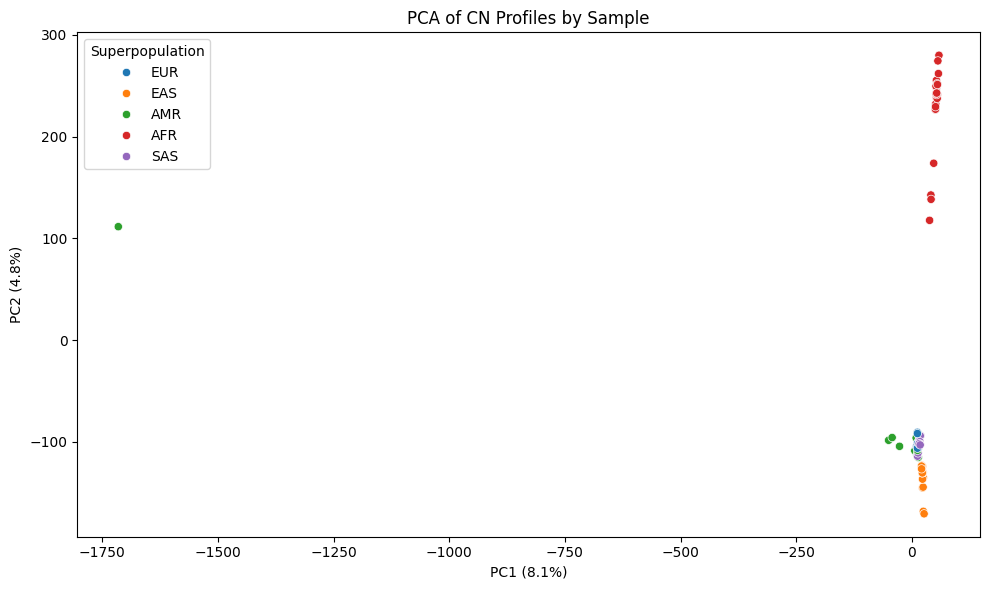

In [39]:
import importlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px



# todo: not all samples are present... NA24385 (HG002) is missing
# observations 
# the sample HG00732_h1 seems to be an outlier in the PCA plot
# the samples have clusters that are mixed with each other...
# TODO: try TSney or UMAP

# # Step 1: Filtering
# # filtering ----
# df = df[df['chrom'].isin([f'chr{i}' for i in range(1, 23)])]

# # Step 2: Create a unique region ID to pivot
# df['region'] = df['chrom'].astype(str) + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)
# 126 s

# # Step 3: Pivot to sample x region matrix (samples as rows)
# pivot_df = df.pivot_table(index='sample', columns='region', values='CN', aggfunc='mean')
# 67 s

# # Step 4: Fill missing CNs (regions not observed for a sample)
# pivot_df = pivot_df.fillna(0)

# std_threshold = 0
# region_std = pivot_df.std(axis=0)
# high_var_regions = region_std[region_std > std_threshold].index
# pivot_df = pivot_df[high_var_regions]
# 1.9 s


# # 547949 regions with more than 0 std


# # Step 5: Normalize (z-score scaling)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(pivot_df)

# # Step 6: PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

## 8.4 s

# # Step 7: Prepare for plotting
# pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# pca_df['sample'] = pivot_df.index

# # Map sample → superpop
# superpop_map = sample_info[['sample', 'superpop']].drop_duplicates().set_index('sample')
# pca_df['superpop'] = pca_df['sample'].map(superpop_map['superpop'])

# Step 8: Plot
# remove the outlier sample
pca_df_filt = pca_df[pca_df['sample']!='HG00732_h1']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_filt, x='PC1', y='PC2', hue='superpop', palette='tab10')
plt.title('PCA of CN Profiles by Sample')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='Superpopulation')
plt.tight_layout()
plt.show()

# outlier: HG00732_h1

# plt.savefig(os.path.join(path, 'population', 'pca_plot.pdf'), format='pdf', bbox_inches='tight')



In [26]:
import time
import pandas as pd

start_time = time.time()

sample_id = sample_order[0]

# Start with the first sample
df_first_sample = df[['chrom', 'start', 'end', 'CN']][df['sample']==sample_id]
df_cum = df_first_sample[['chrom', 'start', 'end', 'CN']].rename(columns={'CN': f'CN_{sample_id}'})

# For each new sample:
for sample_id in sample_order[1:]:
    df_new = df[['chrom', 'start', 'end', 'CN']][df['sample']==sample_id]  # this returns chrom/start/end/CN for this sample
    df_new = df_new.rename(columns={'CN': f'CN_{sample_id}'})
    
    # Merge with the cumulative df
    df_cum = pd.merge(df_cum, df_new, on=['chrom', 'start', 'end'], how='outer')

# Fill NaNs (e.g., regions not present in some samples)
df_cum.fillna(-1, inplace=True)  # or any placeholder to indicate "missing"

missing_val = -1
cn_cols = [col for col in df_cum.columns if col.startswith("CN_")]
results = []

# Convert CN values to integer (optional, speeds things up)
df_cum[cn_cols] = df_cum[cn_cols].astype(int)

# Convert to NumPy array for faster slicing
cn_array = df_cum[cn_cols].to_numpy()

for i in range(1, len(cn_cols) + 1):
    print(f'sample {i}: {sample}')
    current_sample = cn_cols[i-1].replace("CN_", "")
    current_data = cn_array[:, :i]  # shape: (num_regions, num_samples_seen_so_far)

    # Mask missing values
    masked_data = np.where(current_data == missing_val, np.nan, current_data)

    # Count unique alleles per row (region), ignoring NaNs
    # Use np.apply_along_axis for row-wise unique counts
    allele_counts = np.apply_along_axis(
        lambda row: len(set(row[~np.isnan(row)])), axis=1, arr=masked_data
    )

    # Classify
    singleton = np.sum(allele_counts == 1)
    biallelic = np.sum(allele_counts == 2)
    multiallelic = np.sum(allele_counts > 2)

    results.append({
        'sample': current_sample,
        'singleton': singleton,
        'biallelic': biallelic,
        'multiallelic': multiallelic
    })

summary_df = pd.DataFrame(results)



print('merged dataframes', time.time()-start_time)

# 5.8 s

merged dataframes 4.96126127243042


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import population_analysis
importlib.reload(population_analysis)
import time

time_ = time.time()

directory = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc_test/TandemTwist/asm/"
sample_info_file = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/input_folder/samples/hgsvc/HGSVC2_sample_info.tsv"
output_file = 'output/population/population_df_test.csv'

# print('reading the input data')

sample_info = population_analysis.get_sample_info_df(sample_info_file)
df = population_analysis.compute_population_df(directory=directory, sample_info=sample_info, cores=15)

# # 733 s, all samples

# print(f'time elapsed = {time.time()-time_}')
# time_ = time.time()

# # plt_cn_alleles, plot_df_cn_alleles, plot_df_melted_cn_alleles = population_analysis.plot_cumulative_allele_classification(df, value_col="CN")

# # plt_cn_alleles.show()

# # print('computing cumulative allele classification')

#summary_df = population_analysis.compute_cumulative_allele_classification(df, sample_info)

#plt = population_analysis.plot_cumulative_allele_classification(summary_df)

# 104 s (28 s merging) for 12 samples

#print(f'time elapsed = {time.time()-time_}')
# time_ = time.time()

#plt.show()
# 1600 s (26 min) for all samples (both reading and merging and computing cumulative allele classification)


reading sample info
reading vcf file for NA19239_h1reading vcf file for NA19239_h2reading vcf file for NA24385_h1reading vcf file for NA24385_h2reading vcf file for NA19240_h2reading vcf file for NA19240_h1reading vcf file for HG00731_h1

reading vcf file for HG00732_h1reading vcf file for HG00731_h2
reading vcf file for HG00732_h2reading vcf file for HG00733_h1reading vcf file for HG00733_h2










[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc_test/TandemTwist/asm/HG00732_h1.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc_test/TandemTwist/asm/NA19239_h2.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc_test/TandemTwist/asm/NA24385_h1.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc_test/TandemTwist/asm/NA19240_h2.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc_test/TandemTwist/asm/HG00733_h2.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/vntr/output_mar

In [ ]:
plt.save

,sample,sex,pop,superpop
0,HG00268_h1,female,FIN,EUR
1,HG00512_h1,male,CHS,EAS
2,HG00733_h1,female,PUR,AMR
3,HG00732_h1,female,PUR,AMR
4,HG00864_h1,female,CDX,EAS
...,...,...,...,...
83,NA19983_h2,female,ASW,AFR
84,HG03683_h2,female,STU,SAS
85,NA19650_h2,male,MXL,AMR
86,NA19434_h2,female,LWK,AFR


In [11]:
path = '/confidential/tGenVar/vntr/output_maryam/tools/tandemtwister-vis-maryam/scripts/output'
plt.savefig(os.path.join(path, 'population', 'cum_allele_count.pdf'), format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

# Computing sequence similarity

In [ ]:
asm_h1_file = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc/TandemTwist/asm/cut_reads_NA24385_h1.tsv.fasta"
asm_h2_file = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/hgsvc/TandemTwist/asm/cut_reads_NA24385_h2.tsv.fasta"

asm_h1 = parse_fasta.parse_fasta_reads_cut(fasta_file = asm_h1_file, seq_col_name = "asm_h1_seq")
asm_h2 = parse_fasta.parse_fasta_reads_cut(fasta_file = asm_h2_file, seq_col_name = "asm_h2_seq")

asm_df = pd.merge(asm_h1, asm_h2, on=['chrom', 'start', 'end'], how='inner')

asm_h1

In [ ]:
filtered_df = asm_df[
    (asm_df['asm_h1_seq'].isnull()) |
    (asm_df['asm_h2_seq'].isnull())
]
filtered_df

In [ ]:
child_df_tandem_twister_compare = compare_with_asm.compare_sample_to_asm(child_df_tandem_twister.head(100000), asm_df)
# memory allocation error

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
subset  = child_df_tandem_twister_compare[
    child_df_tandem_twister_compare['seq_sim'] < 0.55
]

# subset['motif_ids_H1', 'motif_ids_H2', 'motif_concat_h1', 'motif_concat_h2', '']

filtered_df = child_df_tandem_twister_compare[
    (child_df_tandem_twister_compare['motif_concat_h1'] != "NA") &
    (child_df_tandem_twister_compare['motif_concat_h2'] != "NA")
]
filtered_df



In [ ]:

# Pairs of dataframes and their corresponding output labels
dataframe_pairs = [
    (child_df_tandem_twister.head(100000), "child_df_tandem_twister_compare"),
    #(child_df_tandem_twister_clr.head(10000), "child_df_tandem_twister_clr_compare"),
    #(child_df_tandem_twister_ont.head(10000), "child_df_tandem_twister_ont_compare"),
    (child_df_vamos.head(100000), "child_df_vamos_compare"),
    #(child_df_vamos_clr.head(10000), "child_df_vamos_clr_compare"),
    #(child_df_vamos_ont.head(10000), "child_df_vamos_ont_compare"),
    (child_df_tandem_TRGT.head(100000), "child_df_TRGT_compare")
]

# Dictionary to store results
results = {}

# Process each pair of DataFrames one by one
for df, label in dataframe_pairs:
    try:
        # Call the function with each pair of DataFrames
        result = compare_with_asm.compare_sample_to_asm(df, asm_df)
        mean_seq_sim = result['seq_sim'].dropna().mean()
        mean_len_sim = result['len_sim'].dropna().mean()
        print(f"{label}, mean seq_sim = {mean_seq_sim}, mean len_sim = {mean_len_sim}")
        # Store the result using the label as the key
        results[label] = result
    except Exception as e:
        print(f'Function call raised an exception for {label}: {e}')

# # Using ProcessPoolExecutor for parallel execution across multiple cores
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     # Map the function over the dataframe pairs
#     future_to_label = {
#         executor.submit(compare_with_asm.compare_sample_to_asm, df, asm_df): label
#         for df, label in dataframe_pairs
#     }

#     # Collect results as they complete
#     for future in concurrent.futures.as_completed(future_to_label):
#         label = future_to_label[future]
#         try:
#             result = future.result()
#             results[label] = result
#         except Exception as e:
#             print(f'Function call raised an exception for {label}: {e}')


# print('compare tandemtwister ccs with assembly')
# child_df_tandem_twister_compare = compare_with_asm.compare_sample_to_asm(child_df_tandem_twister.head(100000), asm_df)
# pd.set_option('display.max_colwidth', None)
# child_df_tandem_twister_compare[['chrom', 'start',	'end', 'motif_concat_h1', 'motif_concat_h2', 'asm_h1_seq', 'asm_h2_seq', 'seq_sim', 'len_sim', 'assigned_haplotype']]
# tandemtwist_ccs_merge_asm.to_csv('tandemtwist_ccs_compare_asm.csv', index=False)
# 882 s --- one df size 1.2 M


In [ ]:
# heatmap hex plots 
tantwist = sns.jointplot(data = tandemtwist_ccs_merge_asm, x='len_sim', y='seq_sim', kind="hex", color="#4CB391")
tantwist.fig.suptitle("TandemTwister")

# plt2 --- vamos ccs
vamos_plt = sns.jointplot(data = vamos_ccs_merge_asm, x='len_sim', y='seq_sim', kind="hex", color="#4CB391")
vamos_plt.fig.suptitle("Vamos")

# plt3 --- trgt ccs
vamos_plt = sns.jointplot(data = trgt_ccs_merge_asm, x='len_sim', y='seq_sim', kind="hex", color="#4CB391")
vamos_plt.fig.suptitle("TRGT")


# statistics:
mean_seq_sim_tantwist = tandemtwist_ccs_merge_asm['seq_sim'].dropna().mean()
median_seq_sim_tantwist = tandemtwist_ccs_merge_asm['seq_sim'].dropna().median()
mean_len_sim_tantwist = tandemtwist_ccs_merge_asm['len_sim'].dropna().mean()
median_len_sim_tantwist = tandemtwist_ccs_merge_asm['len_sim'].dropna().median()

mean_seq_sim_vamos = vamos_ccs_merge_asm['seq_sim'].dropna().mean()
median_seq_sim_vamos = vamos_ccs_merge_asm['seq_sim'].dropna().median()
mean_len_sim_vamos = vamos_ccs_merge_asm['len_sim'].dropna().mean()
median_len_sim_vamos = vamos_ccs_merge_asm['len_sim'].dropna().median()


mean_seq_sim_trgt = trgt_ccs_merge_asm['seq_sim'].dropna().mean()
median_seq_sim_trgt = trgt_ccs_merge_asm['seq_sim'].dropna().median()
mean_len_sim_trgt = trgt_ccs_merge_asm['len_sim'].dropna().mean()
median_len_sim_trgt = trgt_ccs_merge_asm['len_sim'].dropna().median()


# Create a dictionary to structure your data
data = {
    'mean_seq_sim': [mean_seq_sim_tantwist, mean_seq_sim_vamos, mean_seq_sim_trgt],
    'median_seq_sim': [median_seq_sim_tantwist, median_seq_sim_vamos, median_seq_sim_trgt],
    'mean_len_sim': [mean_len_sim_tantwist, mean_len_sim_vamos, mean_len_sim_trgt],
    'median_len_sim': [median_len_sim_tantwist, median_len_sim_vamos, median_len_sim_trgt]
}

# Define the index labels (row labels)
index_labels = ['tantwist', 'vamos', 'trgt']

# Create a DataFrame
df = pd.DataFrame(data, index=index_labels)

# Display the DataFrame
df

In [ ]:
print('compare trgt ccs with assembly')
trgt_ccs_merge_asm = compare_with_asm.compare_sample_to_asm(child_df_tandem_TRGT.head(100000), asm_df)
pd.set_option('display.max_colwidth', None)
trgt_ccs_merge_asm[['chrom', 'start',	'end', 'motif_concat_h1', 'motif_concat_h2', 'asm_h1_seq', 'asm_h2_seq', 'seq_sim', 'len_sim', 'assigned_haplotype']]

# trgt_ccs_merge_asm.to_csv('trgt_ccs_compare_asm.csv', index=False)

In [ ]:
print('compare trgt ccs with assembly')
vamos_ccs_merge_asm = compare_with_asm.compare_sample_to_asm(child_df_vamos.head(100000), asm_df)
pd.set_option('display.max_colwidth', None)
vamos_ccs_merge_asm[['chrom', 'start',	'end', 'motif_concat_h1', 'motif_concat_h2', 'asm_h1_seq', 'asm_h2_seq', 'seq_sim', 'len_sim', 'assigned_haplotype']]

vamos_ccs_merge_asm.to_csv('vamos_ccs_compare_asm.csv', index=False)

In [ ]:
plot = plot_heatmap_with_histograms(tandemtwist_ccs_merge_asm.head(10000))
plot.show()

In [ ]:
# tandemtwist_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = tandemtwist_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')
tandemtwist_clr_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = tandemtwist_clr_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')
tandemtwist_ont_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = tandemtwist_ont_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')

tandemtwist_clr_compare_asm

# true_count = tandemtwist_compare_asm['ambiguous_motifs'].sum()
# print(f"Number of 'all ambiguous_motifs' regions: {true_count}") # 207324

In [ ]:
# vamos_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = vamos_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')
vamos_clr_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = vamos_clr_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')
vamos_ont_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = vamos_ont_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')

vamos_clr_compare_asm

# true_count = vamos_compare_asm['ambiguous_motifs'].sum()
# print(f"Number of 'all ambiguous_motifs' regions: {true_count}") # 210781

In [ ]:
trgt_compare_asm[['MAE_motif_count', 'relative_MAE_motif_count', 'ambiguous_motifs']] = trgt_compare_asm.apply(compare_counts_with_asm, axis=1, result_type='expand')

trgt_compare_asm

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Merge DataFrames on 'chrom', 'start', 'end'


# First, merge the first two DataFrames
merged_df_1 = pd.merge(
    tandemtwist_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    vamos_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    on=['chrom', 'start', 'end'],
    suffixes=('_tandemtwist', '_vamos')
)

# Then, merge the result with the third DataFrame
merged_df = pd.merge(
    merged_df_1,
    trgt_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    on=['chrom', 'start', 'end'],
    suffixes=('', '_trgt')  # No suffix for the first, and '_trgt' for the second
)

# Rename the columns in merged_df to include the suffix '_trgt'
merged_df.rename(columns={
    'MAE_motif_count': 'MAE_motif_count_trgt',
    'relative_MAE_motif_count': 'relative_MAE_motif_count_trgt'
}, inplace=True)


# # Calculate mean and median values of relative_MAE for each tool
# mean_relative_MAE_tandemtwist = merged_df['relative_MAE_motif_count_tandemtwist'].dropna().mean()
# mean_relative_MAE_vamos = merged_df['relative_MAE_motif_count_vamos'].dropna().mean()
# mean_relative_MAE_trgt = merged_df['relative_MAE_motif_count_trgt'].dropna().mean()
# median_relative_MAE_tandemtwist = merged_df['relative_MAE_motif_count_tandemtwist'].dropna().median()
# median_relative_MAE_vamos = merged_df['relative_MAE_motif_count_vamos'].dropna().median()
# median_relative_MAE_trgt = merged_df['relative_MAE_motif_count_trgt'].dropna().median()

# print(f"Mean Relative MAE (TandemTwist): {mean_relative_MAE_tandemtwist}")
# print(f"Mean Relative MAE (VAMOS): {mean_relative_MAE_vamos}")
# print(f"Mean Relative MAE (TRGT): {mean_relative_MAE_trgt}")
# print(f"Median Relative MAE (TandemTwist): {median_relative_MAE_tandemtwist}")
# print(f"Median Relative MAE (VAMOS): {median_relative_MAE_vamos}")
# print(f"Median Relative MAE (TRGT): {median_relative_MAE_trgt}")

# # Trim the top 5% of relative_MAEs for each tool
tandemtwist_trimmed = merged_df['MAE_motif_count_tandemtwist'].dropna() # merged_df['relative_MAE_motif_count_tandemtwist'].dropna()
vamos_trimmed = merged_df['MAE_motif_count_vamos'].dropna() # merged_df['relative_MAE_motif_count_vamos'].dropna()
trgt_trimmed = merged_df['MAE_motif_count_trgt'].dropna() # merged_df['relative_MAE_motif_count_trgt'].dropna()

tandemtwist_trimmed = tandemtwist_trimmed[tandemtwist_trimmed <= tandemtwist_trimmed.quantile(0.95)]
vamos_trimmed = vamos_trimmed[vamos_trimmed <= vamos_trimmed.quantile(0.95)]
trgt_trimmed = trgt_trimmed[trgt_trimmed <= trgt_trimmed.quantile(0.95)]


# Calculate mean and median values of MAE for each tool
mean_MAE_tandemtwist = merged_df['MAE_motif_count_tandemtwist'].dropna().mean()
mean_MAE_vamos = merged_df['MAE_motif_count_vamos'].dropna().mean()
mean_MAE_trgt = merged_df['MAE_motif_count_trgt'].dropna().mean()
# median_MAE_tandemtwist = merged_df['MAE_motif_count_tandemtwist'].dropna().median()
# median_MAE_vamos = merged_df['MAE_motif_count_vamos'].dropna().median()
# median_MAE_trgt = merged_df['MAE_motif_count_trgt'].dropna().median()

print(f"Mean MAE (TandemTwist): {mean_MAE_tandemtwist}")
print(f"Mean MAE (VAMOS): {mean_MAE_vamos}")
print(f"Mean MAE (TRGT): {mean_MAE_trgt}")

# Prepare data for plotting
trimmed_data = pd.DataFrame({
    'Tool': ['TandemTwist'] * len(tandemtwist_trimmed) + ['VAMOS'] * len(vamos_trimmed) + ['TRGT'] * len(trgt_trimmed),
    'MAE': pd.concat([tandemtwist_trimmed, vamos_trimmed, trgt_trimmed])
})

# Plot (violin)
plt.figure(figsize=(10, 6))
sns.violinplot(data=trimmed_data, x='Tool', y='MAE')
plt.title("Trimmed Violin Plot of MAE for Different Tools (Top 5% Removed)")
plt.show()

# # Create box plots
# plt.figure(figsize=(10, 6))
# plt.boxplot([trimmed_data[trimmed_data['Tool'] == 'TandemTwist']['MAE'],
#              trimmed_data[trimmed_data['Tool'] == 'VAMOS']['MAE']],
#             labels=['TandemTwist', 'VAMOS'])

# plt.ylabel('MAE')
# plt.title('Box Plot of MAE for Different Tools (Top 5% Removed)')
# plt.grid(axis='y')
# plt.show()

In [ ]:
merged_df_clr = pd.merge(
    tandemtwist_clr_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    vamos_clr_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    on=['chrom', 'start', 'end'],
    suffixes=('_tandemtwist', '_vamos')
)

merged_df_ont = pd.merge(
    tandemtwist_ont_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    vamos_ont_compare_asm[['chrom', 'start', 'end', 'MAE_motif_count', 'relative_MAE_motif_count']],
    on=['chrom', 'start', 'end'],
    suffixes=('_tandemtwist', '_vamos')
)

tandemtwist_trimmed_clr = merged_df_clr['MAE_motif_count_tandemtwist'].dropna() 
vamos_trimmed_clr = merged_df_clr['MAE_motif_count_vamos'].dropna()
tandemtwist_trimmed_clr = tandemtwist_trimmed_clr[tandemtwist_trimmed_clr <= tandemtwist_trimmed_clr.quantile(0.95)]
vamos_trimmed_clr = vamos_trimmed_clr[vamos_trimmed_clr <= vamos_trimmed_clr.quantile(0.95)]

tandemtwist_trimmed_ont = merged_df_ont['MAE_motif_count_tandemtwist'].dropna()
vamos_trimmed_ont = merged_df_ont['MAE_motif_count_vamos'].dropna()
tandemtwist_trimmed_ont = tandemtwist_trimmed_ont[tandemtwist_trimmed_ont <= tandemtwist_trimmed_ont.quantile(0.95)]
vamos_trimmed_ont = vamos_trimmed_ont[vamos_trimmed_ont <= vamos_trimmed_ont.quantile(0.95)]

mean_MAE_tandemtwist_clr = merged_df_clr['MAE_motif_count_tandemtwist'].dropna().mean()
mean_MAE_vamos_clr = merged_df_clr['MAE_motif_count_vamos'].dropna().mean()
print(f"Mean MAE CLR (TandemTwist): {mean_MAE_tandemtwist_clr}")
print(f"Mean MAE CLR (VAMOS): {mean_MAE_vamos_clr}")

mean_MAE_tandemtwist_ont = merged_df_ont['MAE_motif_count_tandemtwist'].dropna().mean()
mean_MAE_vamos_ont = merged_df_ont['MAE_motif_count_vamos'].dropna().mean()
print(f"Mean MAE ONT (TandemTwist): {mean_MAE_tandemtwist_ont}")
print(f"Mean MAE ONT (VAMOS): {mean_MAE_vamos_ont}")

# Prepare data for plotting
trimmed_data = pd.DataFrame({
    'Tool': ['TandemTwist'] * len(tandemtwist_trimmed_clr) + ['VAMOS'] * len(vamos_trimmed_clr) + ['TandemTwist'] * len(tandemtwist_trimmed_ont) + ['VAMOS'] * len(vamos_trimmed_ont),
    'Tech': ['CLR'] * (len(tandemtwist_trimmed_clr)+len(vamos_trimmed_clr)) + ['ONT'] * (len(tandemtwist_trimmed_ont)+len(vamos_trimmed_ont)),
    'MAE': pd.concat([tandemtwist_trimmed_clr, vamos_trimmed_clr, tandemtwist_trimmed_ont, vamos_trimmed_ont])
})

# Plot (violin)
plt.figure(figsize=(10, 6))
sns.violinplot(data=trimmed_data, x='Tech', hue='Tool', y='MAE')
plt.title("Trimmed Violin Plot of MAE for Different Tools (Top 5% Removed)")
plt.show()


In [ ]:
# read the motif file
motif_file = "/confidential/tGenVar/Lion/TandemTwist/vamos.motif.hg38.v2.1.e0.1.tsv"
# read the first 4 columns of the motif file
motif_df = pd.read_csv(motif_file, sep='\t', usecols=[0, 1, 2, 3], header=None)
# create a header 
motif_df.columns = ['chrom', 'start', 'end', 'motifs']
# merge the child results of the three tools with the motif file
df = motif_df.merge(child_df_tandem_twister, on=['chrom', 'start', 'end'], how='left', suffixes=('_motif', '_tandem_twister'))
df = df.merge(child_df_tandem_TRGT, on=['chrom', 'start', 'end',], how='left', suffixes=('_tandem_twister', '_TRGT'))
df = df.merge(child_df_vamos, on=['chrom', 'start', 'end'], how='left', suffixes=('_TRGT', '_vamos'))

copynumbers = df[['chrom','start','end','motifs_motif','CN_H1_tandem_twister','CN_H2_tandem_twister','CN_H1_TRGT','CN_H2_TRGT','CN_H1','CN_H2' ]]
copynumbers.columns = ['chrom','start','end','motifs','CN_H1_tandem_twister','CN_H2_tandem_twister','CN_H1_TRGT','CN_H2_TRGT','CN_H1_vamos','CN_H2_vamos']
# make the CN columns as integers
# fill the nan values with 0
copynumbers = copynumbers.fillna(0)

copynumbers['CN_H1_tandem_twister'] = copynumbers['CN_H1_tandem_twister'].astype(int)
copynumbers['CN_H2_tandem_twister'] = copynumbers['CN_H2_tandem_twister'].astype(int)
copynumbers['CN_H1_TRGT'] = copynumbers['CN_H1_TRGT'].astype(int)
copynumbers['CN_H2_TRGT'] = copynumbers['CN_H2_TRGT'].astype(int)
copynumbers['CN_H1_vamos'] = copynumbers['CN_H1_vamos'].astype(int)
copynumbers['CN_H2_vamos'] = copynumbers['CN_H2_vamos'].astype(int)
copynumbers['agreement'] = copynumbers.apply(check_agreement, axis=1)



copynumbers['tandem_twister_disagree'] = copynumbers['agreement'] == 'tandem_twister_disagree'
copynumbers['TRGT_disagree'] = copynumbers['agreement'] == 'TRGT_disagree'
copynumbers['vamos_disagree'] = copynumbers['agreement'] == 'vamos_disagree'
copynumbers['all_disagree'] = copynumbers['agreement'] == 'all_disagree'
copynumbers['all_agree'] = copynumbers['agreement'] == 'all_agree'

# Convert to integer binary representation (0 or 1)
binary_columns = copynumbers[['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree']].astype(int)

# Group the data by combinations of binary columns and count occurrences
counts = binary_columns.groupby(
    ['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree']
).size()

# Reset the index to convert it to a MultiIndex, which is required for UpSet
counts = counts.reset_index()

# Convert columns into a MultiIndex for the UpSet plot
counts = counts.set_index(['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree'])[0]

# Create the UpSet plot
upset = UpSet(counts, orientation='horizontal')
upset.plot()


# Show the plot
plt.show()

In [ ]:
pd.set_option('display.max_rows', 200)
copynumbers.head(200)
# make an upset plot from the column all_agree
copynumbers[copynumbers['tandem_twister_disagree'] == 1].head(200)
# check this region for tandemTwister	
# chr1:104161-104196	
# chr1	109565	109614 # in this region tandemtwister is right and vamos, TRGT are wrong
# check these : chr1	178283	178336,  chr1	933011	933048
# chr1	414630	414675	the region is clearly hetrotzygous but vamos and TRGT reports it as homozygous
# chr1	640899	640928 homopolymer region, TRGT and Vamos are wrong in this region
# chr1	1845825	1845872  # this is an interesting region, tandemtwister is right and vamos, TRGT are wrong, it is a hetrotzygous region
# interesting region : chr1:432,156-432,331
# look at this region in TandemTwister chr1	9311161	9311178 we say it's hetrotzygous but TRGT and Vamos say it's homozygous which is true 
# chr1	1604266	1604292 this region is genotyped correctly by tandemtwister but not by others
# very differen results :chr1	7551284	7551372	


In [ ]:
def get_number_of_motifs_found_in_region(row):
    # get the unique motifs in the region
    if pd.isna(row['motif_ids_H1']) or pd.isna(row['motif_ids_H2']):
        return 0
    
    return max(len(set(row['motif_ids_H1'])), len(set(row['motif_ids_H2'])))

In [ ]:
child_df_tandem_twister['number_of_motifs_found'] = child_df_tandem_twister.apply(get_number_of_motifs_found_in_region, axis=1)
child_df_tandem_TRGT['number_of_motifs_found'] = child_df_tandem_TRGT.apply(get_number_of_motifs_found_in_region, axis=1)
child_df_vamos['number_of_motifs_found'] = child_df_vamos.apply(get_number_of_motifs_found_in_region, axis=1)

child_df_tandem_twister['index'] = child_df_tandem_twister.index
child_df_tandem_TRGT['index'] = child_df_tandem_TRGT.index
child_df_vamos['index'] = child_df_vamos.index

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the data with different markers and transparency for better distinction
ax.scatter(child_df_tandem_twister['index'], child_df_tandem_twister['number_of_motifs_found'], 
           label='Tandem Twister', marker='o', color='blue', alpha=0.7)
ax.scatter(child_df_vamos['index'], child_df_vamos['number_of_motifs_found'], 
           label='Vamos', marker='x', color='green', alpha=0.7)
ax.scatter(child_df_tandem_TRGT['index'], child_df_tandem_TRGT['number_of_motifs_found'], 
           label='TRGT', marker='^', color='red', alpha=0.7)

# Set labels and title
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Number of Motifs Found', fontsize=12)
ax.set_title('Comparison of Motif Finding Tools', fontsize=14)

# Add gridlines for easier reading of points
ax.grid(True)

# Add a legend in the upper right corner
ax.legend(loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:


tandemtwister = get_mendelian_consistency(child_df_tandem_twister, father_df_tandem_twister, mother_df_tandem_twister, 'tandem_twister', child_sex)
#print_mendalian_consistency_per_motif_size(tandemtwister)
print ("number of regions in tandemtwister ", tandemtwister.shape[0])   
print("percentage of mendelian consistent regions for tandemtwister ", tandemtwister['mendelian_consistent_0'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent off by one regions for tandemtwister ", tandemtwister['mendelian_consistent_1'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("percentage of mendelian consistent off by one regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent_1'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("recall for tandemtwister ", tandemtwister.shape[0]/1243954)


In [ ]:
print ("number of regions in tandemtwister ", tandemtwister.shape[0])   
print("percentage of mendelian consistent regions for tandemtwister ", tandemtwister['mendelian_consistent_0'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("recall for tandemtwister ", tandemtwister.shape[0]/1243954)

In [ ]:
tandemtwister[tandemtwister["mendelian_consistent_0"] == True][["CN_H1_child", "CN_H2_child", "CN_H1_father", "CN_H2_father", "CN_H1_mother", "CN_H2_mother", "mendelian_consistent_0", "chrom", "start", "end", "motifs_child", "motif_ids_H1_child", "motif_ids_H2_child", "motif_ids_H1_father", "motif_ids_H2_father", "motif_ids_H1_mother", "motif_ids_H2_mother"]]
# count the number of regions where all CNs are 0
tandemtwister[(tandemtwister["CN_H1_child"] == 0) & (tandemtwister["CN_H2_child"] == 0) & (tandemtwister["CN_H1_father"] == 0) & (tandemtwister["CN_H2_father"] == 0) & (tandemtwister["CN_H1_mother"] == 0) & (tandemtwister["CN_H2_mother"] == 0)]


In [ ]:
tandemtwister[tandemtwister["max_motif_size"] ==1]

In [ ]:
TRGT = get_mendelian_consistency(child_df_tandem_TRGT, father_df_tandem_TRGT, mother_df_tandem_TRGT, 'TRGT',child_sex)
#print_mendalian_consistency_per_motif_size(TRGT)
print ("number of  regions in TRGT ", TRGT.shape[0])
print("Number of mendelian consistent regions for TRGT ", TRGT['mendelian_consistent_0'].sum()/TRGT.shape[0])
print("Number of mendelian consistent off by one regions for TRGT ", TRGT['mendelian_consistent_1'].sum()/TRGT.shape[0])
print("Number of mendelian consistent regions for TRGT with motif size > 1 ", TRGT[TRGT['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/TRGT[TRGT['max_motif_size'] > 1].shape[0])



In [ ]:
vamos = get_mendelian_consistency(child_df_vamos, father_df_vamos, mother_df_vamos, 'vamos',child_sex)
#print_mendalian_consistency_per_motif_size(vamos)
print ("number of regions in vamos ", vamos.shape[0])
print("Number of mendelian consistent regions for vamos ", vamos['mendelian_consistent_0'].sum()/vamos.shape[0])
print("Number of mendelian consistent off by one regions for vamos ", vamos['mendelian_consistent_1'].sum()/vamos.shape[0])
print("Number of mendelian consistent regions for vamos with motif size > 1 ", vamos[vamos['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/vamos[vamos['max_motif_size'] > 1].shape[0])
print("Number of mendelian consistent regions off by one for vamos with motif size > 1 ", vamos[vamos['max_motif_size'] > 1]['mendelian_consistent_1'].sum()/vamos[vamos['max_motif_size'] > 1].shape[0])
print("recall for vamos ", vamos.shape[0]/1243954)

#### CLR 
# number of regions in vamos  1239659
# Number of mendelian consistent regions for vamos  0.43918287206401113
# Number of mendelian consistent off by one regions for vamos  0.7118239774002367
# Number of mendelian consistent regions for vamos with motif size > 1  0.5369489043460071
# Number of mendelian consistent regions off by one for vamos with motif size > 1  0.8087400432690204
# recall for vamos  0.9965472999805459



In [ ]:
TandemTwister_MC =  tandemtwister['mendelian_consistent_0'].sum()/tandemtwister.shape[0]
#TandemTwister_MC_motif =  tandemtwister['mendelian_consistent_0_motif'].sum()/tandemtwister.shape[0]
Vamos_MC = vamos['mendelian_consistent_0'].sum()/vamos.shape[0]
#Vamos_MC_motif = vamos['mendelian_consistent_0_motif'].sum()/vamos.shape[0]

#TRGT_MC = TRGT['mendelian_consistent_0'].sum()/TRGT.shape[0]
#TRGT_MC_motif = TRGT['mendelian_consistent_0_motif'].sum()/TRGT.shape[0]

In [ ]:
TandemTwister_MC_off_by_one = tandemtwister['mendelian_consistent_1'].sum()/tandemtwister.shape[0]
#TandemTwister_MC_off_by_one_motif = tandemtwister['mendelian_consistent_1_motif'].sum()/tandemtwister.shape[0]
Vamos_MC_off_by_one = vamos['mendelian_consistent_1'].sum()/vamos.shape[0]
#Vamos_MC_off_by_one_motif = vamos['mendelian_consistent_1_motif'].sum()/vamos.shape[0]

#TRGT_MC_off_by_one = TRGT['mendelian_consistent_1'].sum()/TRGT.shape[0]
##TRGT_MC_off_by_one_motif = TRGT['mendelian_consistent_1_motif'].sum()/TRGT.shape[0]

In [ ]:
recall_TandemTwister_MC = tandemtwister.shape[0]/1243954
recall_Vamos_MC = vamos.shape[0]/1243954
#recall_TRGT_MC = TRGT.shape[0]/1243954



In [ ]:
print("TandemTwister_MC =", TandemTwister_MC)
print("Vamos_MC =", Vamos_MC)
#print("TRGT_MC ", TRGT_MC)


print("TandemTwister_MC_off_by_one= ", TandemTwister_MC_off_by_one)
print("Vamos_MC_off_by_one =", Vamos_MC_off_by_one)
#print("TRGT_MC_off_by_one ", TRGT_MC_off_by_one)

print("recall_TandemTwister_MC = ", recall_TandemTwister_MC)
print("recall_Vamos_MC =", recall_Vamos_MC)
#print("recall_TRGT_MC ", recall_TRGT_MC)






In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

TandemTwister_MC_CCS = 0.9487292577123414
Vamos_MC_CCS = 0.812866225853674
TRGT_MC_CCS = 0.9535301374278667

TandemTwister_MC_off_by_one_CCS = 0.9847607682507942
Vamos_MC_off_by_one_CCS = 0.9566472748871735
TRGT_MC_off_by_one_CCS = 0.9890338847628842

recall_TandemTwister_MC_CCS = 0.997
recall_Vamos_MC_CCS = 0.993
recall_TRGT_MC_CCS = 0.995

TandemTwister_MC_CLR = 0.5178540904033155
Vamos_MC_CLR = 0.43918287206401113

TandemTwister_MC_off_by_one_CLR = 0.8182814339391399
Vamos_MC_off_by_one_CLR = 0.7118239774002367

recall_TandemTwister_MC_CLR = 0.9969982812869286
recall_Vamos_MC_CLR = 0.9965472999805459

TandemTwister_MC_ONT = 0.6353058328361098
Vamos_MC_ONT = 0.49914080605957833
TandemTwister_MC_off_by_one_ONT=  0.8663083968973246
Vamos_MC_off_by_one_ONT = 0.7762518471862206
recall_TandemTwister_MC_ONT =  0.9969982812869286
recall_Vamos_MC_ONT = 0.9955110880305863



# Round the values to 2 or 3 decimal places for better readability
Vamos_MC_CCS = round(Vamos_MC_CCS, 3)
TRGT_MC_CCS = round(TRGT_MC_CCS, 3)
TandemTwister_MC_CCS = round(TandemTwister_MC_CCS, 3)

Vamos_MC_off_by_one_CCS = round(Vamos_MC_off_by_one_CCS, 3)
TRGT_MC_off_by_one_CCS = round(TRGT_MC_off_by_one_CCS, 3)
TandemTwister_MC_off_by_one_CCS = round(TandemTwister_MC_off_by_one_CCS, 3)

recall_Vamos_MC_CCS = round(recall_Vamos_MC_CCS, 3)
recall_TRGT_MC_CCS = round(recall_TRGT_MC_CCS, 3)
recall_TandemTwister_MC_CCS = round(recall_TandemTwister_MC_CCS, 3)

Vamos_MC_CLR = round(Vamos_MC_CLR, 3)
TandemTwister_MC_CLR = round(TandemTwister_MC_CLR, 3)

Vamos_MC_off_by_one_CLR = round(Vamos_MC_off_by_one_CLR, 3)
TandemTwister_MC_off_by_one_CLR = round(TandemTwister_MC_off_by_one_CLR, 3)

recall_Vamos_MC_CLR = round(recall_Vamos_MC_CLR, 3)
recall_TandemTwister_MC_CLR = round(recall_TandemTwister_MC_CLR, 3)


Vamos_MC_ONT = round(Vamos_MC_ONT, 3)
TandemTwister_MC_ONT = round(TandemTwister_MC_ONT, 3)

Vamos_MC_off_by_one_ONT = round(Vamos_MC_off_by_one_ONT, 3)
TandemTwister_MC_off_by_one_ONT = round(TandemTwister_MC_off_by_one_ONT, 3)

recall_Vamos_MC_ONT = round(recall_Vamos_MC_ONT, 3)
recall_TandemTwister_MC_ONT = round(recall_TandemTwister_MC_ONT, 3)
# Data for CCS
tools_CCS = ['Vamos', 'TRGT', 'TandemTwister']
metrics_CCS = ['MC', 'MC Off by One', 'Recall']
values_CCS = [
    [Vamos_MC_CCS, TRGT_MC_CCS, TandemTwister_MC_CCS],  # Mendelian Consistency
    [Vamos_MC_off_by_one_CCS, TRGT_MC_off_by_one_CCS, TandemTwister_MC_off_by_one_CCS],  # Off by One
    [recall_Vamos_MC_CCS, recall_TRGT_MC_CCS, recall_TandemTwister_MC_CCS]  # Recall
]

# Data for CLR
tools_CLR = ['Vamos', 'TandemTwister']
metrics_CLR = ['MC', 'MC Off by One', 'Recall']
values_CLR = [
    [Vamos_MC_CLR, TandemTwister_MC_CLR],  # Mendelian Consistency
    [Vamos_MC_off_by_one_CLR, TandemTwister_MC_off_by_one_CLR],  # Off by One
    [recall_Vamos_MC_CLR, recall_TandemTwister_MC_CLR]  # Recall
]

# Data for ONT
tools_ONT = ['Vamos', 'TandemTwister']
metrics_ONT = ['MC', 'MC Off by One', 'Recall']
values_ONT = [
    [Vamos_MC_ONT, TandemTwister_MC_ONT],  # Mendelian Consistency
    [Vamos_MC_off_by_one_ONT, TandemTwister_MC_off_by_one_ONT],  # Off by One
    [recall_Vamos_MC_ONT, recall_TandemTwister_MC_ONT]  # Recall
]


# Create a subplot figure with 2 columns
fig = make_subplots(rows=2, cols=2, subplot_titles=("CCS Data", "CLR Data", "ONT Data"))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  
# Add traces for CCS
for i, metric in enumerate(metrics_CCS):
    fig.add_trace(go.Bar(
        name=metric,
        x=tools_CCS,
        y=values_CCS[i],
        text=values_CCS[i],
        textposition='inside',
        marker_color=colors[i],
        width=0.2,
        showlegend=True 
    ), row=1, col=1)

# Add traces for CLR
for i, metric in enumerate(metrics_CLR):
    fig.add_trace(go.Bar(
        name=metric,
        x=tools_CLR,
        y=values_CLR[i],
        text=values_CLR[i],
        textposition='inside',
        marker_color=colors[i],
        width=0.2,
        showlegend=False

    ), row=1, col=2)

# Add traces for ONT
for i, metric in enumerate(metrics_ONT):
    fig.add_trace(go.Bar(
        name=metric,
        x=tools_ONT,
        y=values_ONT[i],
        text=values_ONT[i],
        textposition='inside',
        marker_color=colors[i],
        width=0.2,
        showlegend=False
    ), row=2, col=1)

# Update layout
fig.update_layout(
    title="Mendelian Consistency and Recall for Different Tools on Hifi Data (CCS vs CLR)",
    barmode='group',
    xaxis_title="",
    yaxis_title="Scores",
    legend_title="",
    height=700,
    width=1200,
    font=dict(size=14),
    title_font=dict(size=18, family='Arial'),
    plot_bgcolor='rgba(240, 240, 240, 1)',
    showlegend=True,  # Enable single legend for all subplots
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)
# remove the legend from the second subplot
#fig.update_traces(showlegend=False, selector=dict(row=1, col=2))
# Show the plot
fig.show()

# Save the plot as a PDF
# fig.write_image("/confidential/tGenVar/Lion/TandemTwist/MC/paper_figures/mendelian_consistency_recall_CCS_CLR_ONT.pdf", width=1200, height=500)


In [ ]:
import plotly.graph_objects as go

# Combine tools and technologies for x-axis
tools_technologies = [
    'ONT_vamos', 'ONT_TandemTwister',  
    'CLR_vamos', 'CLR_TandemTwister', 
    'CCS_vamos', 'CCS_TandemTwister', 'CCS_TRGT'
]

TandemTwister_MC_CCS = 0.9487292577123414
Vamos_MC_CCS = 0.812866225853674
TRGT_MC_CCS = 0.9535301374278667

TandemTwister_MC_off_by_one_CCS = 0.9847607682507942
Vamos_MC_off_by_one_CCS = 0.9566472748871735
TRGT_MC_off_by_one_CCS = 0.9890338847628842

recall_TandemTwister_MC_CCS = 0.997
recall_Vamos_MC_CCS = 0.993
recall_TRGT_MC_CCS = 0.995

TandemTwister_MC_CLR = 0.5178540904033155
Vamos_MC_CLR = 0.43918287206401113

TandemTwister_MC_off_by_one_CLR = 0.8182814339391399
Vamos_MC_off_by_one_CLR = 0.7118239774002367

recall_TandemTwister_MC_CLR = 0.9969982812869286
recall_Vamos_MC_CLR = 0.9965472999805459

TandemTwister_MC_ONT = 0.6353058328361098
Vamos_MC_ONT = 0.49914080605957833
TandemTwister_MC_off_by_one_ONT=  0.8663083968973246
Vamos_MC_off_by_one_ONT = 0.7762518471862206
recall_TandemTwister_MC_ONT =  0.9969982812869286
recall_Vamos_MC_ONT = 0.9955110880305863



# Round the values to 2 or 3 decimal places for better readability
Vamos_MC_CCS = round(Vamos_MC_CCS, 3)
TRGT_MC_CCS = round(TRGT_MC_CCS, 3)
TandemTwister_MC_CCS = round(TandemTwister_MC_CCS, 3)

Vamos_MC_off_by_one_CCS = round(Vamos_MC_off_by_one_CCS, 3)
TRGT_MC_off_by_one_CCS = round(TRGT_MC_off_by_one_CCS, 3)
TandemTwister_MC_off_by_one_CCS = round(TandemTwister_MC_off_by_one_CCS, 3)

recall_Vamos_MC_CCS = round(recall_Vamos_MC_CCS, 3)
recall_TRGT_MC_CCS = round(recall_TRGT_MC_CCS, 3)
recall_TandemTwister_MC_CCS = round(recall_TandemTwister_MC_CCS, 3)

Vamos_MC_CLR = round(Vamos_MC_CLR, 3)
TandemTwister_MC_CLR = round(TandemTwister_MC_CLR, 3)

Vamos_MC_off_by_one_CLR = round(Vamos_MC_off_by_one_CLR, 3)
TandemTwister_MC_off_by_one_CLR = round(TandemTwister_MC_off_by_one_CLR, 3)

recall_Vamos_MC_CLR = round(recall_Vamos_MC_CLR, 3)
recall_TandemTwister_MC_CLR = round(recall_TandemTwister_MC_CLR, 3)


Vamos_MC_ONT = round(Vamos_MC_ONT, 3)
TandemTwister_MC_ONT = round(TandemTwister_MC_ONT, 3)

Vamos_MC_off_by_one_ONT = round(Vamos_MC_off_by_one_ONT, 3)
TandemTwister_MC_off_by_one_ONT = round(TandemTwister_MC_off_by_one_ONT, 3)

recall_Vamos_MC_ONT = round(recall_Vamos_MC_ONT, 3)
recall_TandemTwister_MC_ONT = round(recall_TandemTwister_MC_ONT, 3)

MC_values = [Vamos_MC_CLR, TandemTwister_MC_CLR, Vamos_MC_ONT, TandemTwister_MC_ONT, Vamos_MC_CCS, TandemTwister_MC_CCS, TRGT_MC_CCS]
MC_off_by_one_values = [Vamos_MC_off_by_one_CLR, TandemTwister_MC_off_by_one_CLR, Vamos_MC_off_by_one_ONT, TandemTwister_MC_off_by_one_ONT, Vamos_MC_off_by_one_CCS, TandemTwister_MC_off_by_one_CCS, TRGT_MC_off_by_one_CCS]
recall_values = [recall_Vamos_MC_CLR, recall_TandemTwister_MC_CLR, recall_Vamos_MC_ONT, recall_TandemTwister_MC_ONT, recall_Vamos_MC_CCS, recall_TandemTwister_MC_CCS, recall_TRGT_MC_CCS]

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, and green

# Create the figure
fig = go.Figure()

# Add Mendelian consistency bars
fig.add_trace(go.Bar(
    name="MC",
    x=tools_technologies,
    y=MC_values,
    text=MC_values,
    textposition='inside',
    marker_color=colors[0],
    width=0.2
))

# Add MC off by one bars
fig.add_trace(go.Bar(
    name="MC_off_by_1",
    x=tools_technologies,
    y=MC_off_by_one_values,
    text=MC_off_by_one_values,
    textposition='inside',
    marker_color=colors[1],
    width=0.2
))

# Add Recall bars
fig.add_trace(go.Bar(
    name="recall",
    x=tools_technologies,
    y=recall_values,
    text=recall_values,
    textposition='inside',
    marker_color=colors[2],
    width=0.2
))

# Update layout
fig.update_layout(
    title="Mendelian Consistency and Recall for Different Tools across Different Technologies",
    barmode='group',
    yaxis_title="Mendelian Consistency and Recall (Percentage)",
    yaxis_range=[0, 1],  # Set range for percentages
    height=600,
    width=1000,
    font=dict(size=14),
    title_font=dict(size=18, family='Arial'),
    plot_bgcolor='rgba(240, 240, 240, 1)',
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=-45)

# Show the plot
fig.show()

# Save the plot as a PDF
fig.write_image("/confidential/tGenVar/Lion/TandemTwist/MC/paper_figures/mendelian_consistency_recall_by_technology.pdf", width=1000, height=600)


In [ ]:
import plotly.graph_objects as go

# Define the data for the comparison table
data = {
    "Features": [
        "Supports CCS_input", 
        "Supports ONT_input", 
        "Supports CLR_input", 
        "Supports assembly input", 
        "Run in parallel", 
    ],
    "TandemTwister": ["✅", "✅", "✅", "✅", "✅"],
    "TRGT": ["❌", "❌", "❌", "✅", "✅",],
    "Vamos": ["✅", "✅", "✅", "✅", "❌"]  # Adding Vamos for comparison
}

# Create a Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Features", "TandemTwister", "Tandem-genotypes", "TRGT"],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[data["Features"], data["TandemTwister"],  data["TRGT"], data["Vamos"]],
               fill_color='lavender',
               align='left'))
])

# Update layout for better visualization
fig.update_layout(
    title="Comparison of Tandem Repeat Genotyping Tools",
    width=800,
    height=400
)

# Show the plot
fig.show()


In [ ]:
tandemtwister_MC_per_motif_size =[tandemtwister[tandemtwister['max_motif_size'] == i]['mendelian_consistent_0'].sum()/tandemtwister[tandemtwister['max_motif_size'] == i].shape[0] for i in range(1, 11)]
tandemtwister_MC_per_motif_size_off_by_one =[tandemtwister[tandemtwister['max_motif_size'] == i]['mendelian_consistent_1'].sum()/tandemtwister[tandemtwister['max_motif_size'] == i].shape[0] for i in range(1, 11)]

vamos_MC_per_motif_size =[vamos[vamos['max_motif_size'] == i]['mendelian_consistent_0'].sum()/vamos[vamos['max_motif_size'] == i].shape[0] for i in range(1, 11)]
vamos_MC_per_motif_size_off_by_one =[vamos[vamos['max_motif_size'] == i]['mendelian_consistent_1'].sum()/vamos[vamos['max_motif_size'] == i].shape[0] for i in range(1, 11)]

print("tandemtwister_MC_per_motif_size = ", tandemtwister_MC_per_motif_size)
print("tandemtwister_MC_per_motif_size_off_by_one = ", tandemtwister_MC_per_motif_size_off_by_one)
print("vamos_MC_per_motif_size = ", vamos_MC_per_motif_size)
print("vamos_MC_per_motif_size_off_by_one = ", vamos_MC_per_motif_size_off_by_one)



In [ ]:
import os
import plotly.graph_objects as go

# Data (as placeholders, since actual data isn't provided)
#### CCS results
# tandemtwister_MC_per_motif_size=  [0.7689604669209666, 0.9506249581025162, 0.9783060261038601, 0.989989024772656, 0.9772590821474841, 0.975196104301101, 0.987943176135058, 0.9869544633620312, 0.982550995330548, 0.9795629820051414]
# trgt_MC_per_motif_size = [0.8325180424243753, 0.9351182774699118, 0.9786415111130887, 0.984628670120898, 0.9802907847812784, 0.9742530006127378, 0.9821694511386099, 0.972425663452588, 0.9614167135621835, 0.9582984748053285]
# vamos_MC_per_motif_size = [0.47793868197510825, 0.7212122468439709, 0.822845786335698, 0.912506900086744, 0.910878375194383, 0.9202378362700312, 0.9611614900086881, 0.96648192135128, 0.9600578156948459, 0.9545043298436087]
# tandemtwister_MC_per_motif_size_off_by_one = [0.945465773337851, 0.9901518060100798, 0.9934351569008609, 0.995931326434619, 0.9866440556567901, 0.9846834744644614, 0.99266047605531, 0.9922673633637846, 0.9900291401888845, 0.9873393316195372]
# trgt_MC_per_motif_size_off_by_one = [0.9887248557702853, 0.9899787613211923, 0.9949941041671302, 0.9954152928246193, 0.9901875962776172, 0.9833599653983396, 0.9871517153610788, 0.9780107838488153, 0.9683806978052898, 0.9660853336765558]
# vamos_MC_per_motif_size_off_by_one = [0.8717629763654868, 0.9447461702701022, 0.9628713197067611, 0.9855985332387036, 0.981680882145045, 0.9840959079592971, 0.9939590573414422, 0.9951966217999472, 0.9917154339702461, 0.9917926845030374]

## CLR results
# tandemtwister_MC_per_motif_size =  [0.12560523755915753, 0.2298907313624757, 0.2530630380449875, 0.27929601756036376, 0.5374714290228463, 0.5476047688727901, 0.7719340929673033, 0.7358454174045694, 0.6719446687497805, 0.6810411311053984]
# tandemtwister_MC_per_motif_size_off_by_one =  [0.542320177499918, 0.6687204051410498, 0.720410996945293, 0.7955785512699906, 0.8920464719451437, 0.8931801280974885, 0.9556925239582066, 0.9538496607108414, 0.9358213671312713, 0.9282133676092545]
# vamos_MC_per_motif_size =  [0.1366035741419747, 0.10479382616431837, 0.19260960882121292, 0.36124891723757774, 0.37433570051262754, 0.4090596454816406, 0.5239567233384853, 0.5430016863406408, 0.5409207610874688, 0.5432345360824742]
# vamos_MC_per_motif_size_off_by_one =  [0.41187526839097544, 0.41807874537065776, 0.5430427933840903, 0.7756220962280495, 0.779523115270658, 0.7969061093480385, 0.8775861601453402, 0.883080382237212, 0.868568212991946, 0.8728737113402062]

## ONT results
tandemtwister_MC_per_motif_size =  [0.32999245843944347, 0.2699233961643235, 0.5114801444043321, 0.6720131702728128, 0.6850398677045261, 0.685525463573776, 0.8191206087885055, 0.7845733022391331, 0.744268511041674, 0.7339974293059126]
tandemtwister_MC_per_motif_size_off_by_one =  [0.6744778289049436, 0.6567453425233559, 0.8327242432657596, 0.9259799310128567, 0.9277746763711435, 0.9281910427711277, 0.9718719165213631, 0.9701039785379881, 0.9574483024962258, 0.9480719794344473]
vamos_MC_per_motif_size =  [0.1844932290129251, 0.1526510684954178, 0.2995403204623063, 0.4920681782396473, 0.4839695733449334, 0.5065281397818322, 0.6072721356814577, 0.6194231715028455, 0.6105777684003235, 0.6121278515272587]
vamos_MC_per_motif_size_off_by_one =  [0.5016500446092462, 0.5057613934917975, 0.6918308379301287, 0.8697055581798142, 0.8538509470120037, 0.8635968722849696, 0.9247027561990754, 0.9290908452188575, 0.9226360023912509, 0.9177729088800103]

# Create Plotly figure
fig = go.Figure()

# Add traces for each dataset
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=tandemtwister_MC_per_motif_size, mode='lines+markers', name='TandemTwister', marker=dict(symbol='circle')))
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=tandemtwister_MC_per_motif_size_off_by_one, mode='lines+markers', name='TandemTwister off by one', marker=dict(symbol='x')))
# fig.add_trace(go.Scatter(x=list(range(1, 11)), y=trgt_MC_per_motif_size, mode='lines+markers', name='TRGT', marker=dict(symbol='circle')))
# fig.add_trace(go.Scatter(x=list(range(1, 11)), y=trgt_MC_per_motif_size_off_by_one, mode='lines+markers', name='TRGT off by one', marker=dict(symbol='x')))
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=vamos_MC_per_motif_size, mode='lines+markers', name='Vamos', marker=dict(symbol='circle')))
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=vamos_MC_per_motif_size_off_by_one, mode='lines+markers', name='Vamos off by one', marker=dict(symbol='x')))


# Update the layout without the invalid grid property
fig.update_layout(
    title='Mendelian Consistency per Motif Size',
    xaxis_title='Motif Size',
    yaxis_title='Mendelian Consistency',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=80)
)
# make the y axis from 0 to 1
fig.update_yaxes(range=[0, 1.1])

# Show the plot
fig.show()
# save the plot as a pdf
fig.write_image("/confidential/tGenVar/Lion/TandemTwist/MC/paper_figures/mendelian_consistency_per_motif_size_ONT.pdf", width=900, height=500)
### CCS results
# tandemtwister_MC_per_motif_size =  [0.7689604669209666, 0.9506249581025162, 0.9783060261038601, 0.989989024772656, 0.9772590821474841, 0.975196104301101, 0.987943176135058, 0.9869544633620312, 0.982550995330548, 0.9795629820051414]
# trgt_MC_per_motif_size = [0.8325180424243753, 0.9351182774699118, 0.9786415111130887, 0.984628670120898, 0.9802907847812784, 0.9742530006127378, 0.9821694511386099, 0.972425663452588, 0.9614167135621835, 0.9582984748053285]
# vamos_MC_per_motif_size = [0.47793868197510825, 0.7212122468439709, 0.822845786335698, 0.912506900086744, 0.910878375194383, 0.9202378362700312, 0.9611614900086881, 0.96648192135128, 0.9600578156948459, 0.9545043298436087]
# tandemtwister_MC_per_motif_size_off_by_one = [0.945465773337851, 0.9901518060100798, 0.9934351569008609, 0.995931326434619, 0.9866440556567901, 0.9846834744644614, 0.99266047605531, 0.9922673633637846, 0.9900291401888845, 0.9873393316195372]
# trgt_MC_per_motif_size_off_by_one = [0.9887248557702853, 0.9899787613211923, 0.9949941041671302, 0.9954152928246193, 0.9901875962776172, 0.9833599653983396, 0.9871517153610788, 0.9780107838488153, 0.9683806978052898, 0.9660853336765558]
# vamos_MC_per_motif_size_off_by_one = [0.8717629763654868, 0.9447461702701022, 0.9628713197067611, 0.9855985332387036, 0.981680882145045, 0.9840959079592971, 0.9939590573414422, 0.9951966217999472, 0.9917154339702461, 0.9917926845030374]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

def plot_MC_by_motif_size(TRGT, tandemtwister, vamos):
    rates = [
        TRGT['mendelian_consistent'].sum() / TRGT.shape[0],
        tandemtwister['mendelian_consistent'].sum() / tandemtwister.shape[0],
        vamos['mendelian_consistent'].sum() / vamos.shape[0]
    ]
    tools = ['TRGT', 'TandemTwister', 'VAMOS']
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=tools, y=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           _               
    return consistency_rate


def plot_mendelian_consistency_rate(tandemtwister, TRGT, vamos):
    rates = [
        mendelian_consistency_rate(tandemtwister, 'TandemTwister'),
        mendelian_consistency_rate(TRGT, 'TRGT'),
        mendelian_consistency_rate(vamos, 'VAMOS')
    ]
    tools = ['TandemTwister', 'TRGT', 'VAMOS']
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=tools, y=rates)
    plt.ylabel('Mendelian Consistency Rate (%)')
    plt.title('Mendelian Consistency Rate by Tool')
    plt.show()

def plot_venn_diagram(tandemtwister, TRGT, vamos):

    plt.figure(figsize=(8, 6))
    regions_tandemtwister = set(tandemtwister[tandemtwister['mendelian_consistent']]['region'])
    regions_TRGT = set(TRGT[TRGT['mendelian_consistent']]['region'])
    regions_vamos = set(vamos[vamos['mendelian_consistent']]['region'])
    plt.figure(figsize=(8, 8))
    venn3(
        [regions_tandemtwister, regions_TRGT, regions_vamos],
        ('TandemTwister', 'TRGT', 'VAMOS')
    )

    plt.title('Number of Regions Called by Each Tool')
    plt.show()
def calcluate_error_rate_by_region(row):
    # calculate the error rate by assiging the hap1_child to either hap1_father or hap2_father and hap2_child to either hap1_mother or hap2_mother based on the minimum error rate
    if (row["chrom"] != "X" and row["chrom"] != "Y"):
        error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
        error_rate_h1_father_h2_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H2_mother'])
        error_rate_h2_father_h1_mother = abs(row['CN_H2_child'] - row['CN_H2_father']) + abs(row['CN_H2_child'] - row['CN_H1_mother'])
        error_rate_h2_father_h2_mother = abs(row['CN_H2_child'] - row['CN_H2_father']) + abs(row['CN_H2_child'] - row['CN_H2_mother'])

        error_rate = min(
            error_rate_h1_father_h1_mother,
            error_rate_h1_father_h2_mother,
            error_rate_h2_father_h1_mother,
            error_rate_h2_father_h2_mother
        )

        return error_rate
    else:
        if row["chrom"] == "X":
            error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
            error_rate_h1_father_h2_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H2_mother'])
            error_rate = min(
                error_rate_h1_father_h1_mother,
                error_rate_h1_father_h2_mother
            )
            return error_rate
        else:
            error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
            error_rate = error_rate_h1_father_h1_mother
            return error_rate
        
def calculate_error_rate(df):
    df['error_rate'] = df.apply(calcluate_error_rate_by_region, axis=1)
    return df

def plot_error_rate(tandemtwister, TRGT, vamos):
    plt.figure(figsize=(8, 6))
    sns.histplot(tandemtwister['error_rate'], bins=100, color='blue', label='TandemTwister', kde=True)
    sns.histplot(TRGT['error_rate'], bins=100, color='red', label='TRGT', kde=True)
    #sns.histplot(vamos['error_rate'], bins=100, color='green', label='VAMOS', kde=True)
    plt.xlabel('Error Rate')
    plt.ylabel('Number of Regions')
    plt.title('Error Rate Distribution by Tool')
    plt.legend()
    plt.show()

tandemtwister = calculate_error_rate(tandemtwister)
TRGT = calculate_error_rate(TRGT)
# vamos = calculate_error_rate(vamos)




plot_mendelian_consistency_rate(tandemtwister, TRGT, vamos)
plot_venn_diagram(tandemtwister, TRGT, vamos)
plot_error_rate(tandemtwister, TRGT, vamos)

In [ ]:
TRGT 

In [ ]:
tandemtwister_nan = tandemtwister[tandemtwister.isna().any(axis=1)]
tandemtwister_nan.loc[tandemtwister["error_rate"] == tandemtwister["error_rate"].max()]
#N_H1=4821;CN_H2=4839

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties

prop = FontProperties(fname='/usr/share/fonts/truetype/Roboto-Italic.ttf', size=12)
data = [
    (1, 3, 'CTT'),
    (5, 7, 'CTC'),
    (8, 10, 'CTG'),
    (11, 13, 'CTC'),
    (14, 16, 'CTT'),
    (17, 19, 'CTG'),
    (20, 22, 'CTG'),
    (23, 25, 'CTG'),
    (26, 28, 'CTT'),
    (29, 31, 'CTC'),
    (32, 34, 'CAG'),
    (35, 37, 'CTT'),
    (41, 43, 'CTC'),
    (44, 46, 'CTT'),
    (47, 50, 'CATG'),
    (51, 53, 'CTG'),
]
colors = {
    'CTT': 'blue',
    'CTC': 'green',
    'CTG': 'orange',
    'CAG': 'red',
    'CATG': 'purple'
}

fig, ax = plt.subplots(figsize=(30, 10))  # Increase height of the figure

# Adjust width and height scaling factors
width_scale = 1  # One box per base pair
height_scale = 0.1  # Height of each box

# Track covered positions
covered_positions = set()

# Create base pair positions with colors based on motifs
for (start, end, motif) in data:
    for position in range(start, end + 1):
        rect = FancyBboxPatch((position * width_scale, 0.5), width_scale, 0.5 * height_scale, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', 
                              facecolor=colors[motif],
                              mutation_aspect=0.5)
        ax.add_patch(rect)
        covered_positions.add(position)
        ax.text(position * width_scale + 0.5, 0.50, motif[position - start], ha='center', va='center', color="black", fontsize=15, fontproperties=prop)

# Add gray boxes for base pairs not covered by any motifs
for i in range(1, 55):
    if i not in covered_positions:
        rect = FancyBboxPatch((i * width_scale, 0.5), width_scale, 0.5 * height_scale, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', 
                              facecolor='gray',
                              mutation_aspect=0.5)
        ax.add_patch(rect)

# Set the limits of the plot
ax.set_xlim(0, 54 * width_scale)
ax.set_ylim(0, 2)

# Remove axes and ticks
ax.axis('off')

# Add an annotation on the plot that shows the total size of the region 
ax.annotate('Total size: 54 bp', xy=(0, 1.5), xytext=(0, 1.5), fontsize=12, fontproperties=prop)

# Add an annotation that shows the position of each base pair underneath the boxes
for i in range(0, 54):
    ax.annotate(str(i+1), xy=(i * width_scale, 0.45), xytext=(i * width_scale, 0.35), fontsize=12, fontproperties=prop)

# Add a more stylish legend
handles = [FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.1", edgecolor='black', facecolor=colors[motif]) for motif in colors]
labels = list(colors.keys())
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop=prop)

# Display the plot
plt.show()
#CTT,CTC,CTG,CAG,CATG;SVTYPE=VNTR;ALTANNO_H1=0,1,2,1,0,2,0,0,0,1,3,0,2,1,0,4,2 Vamos
# CATG,CTT,CTC,CTG,CAG    1,2,3,2,1,3,3,3,1,2,4,1,2,1,0,3 TandemTwister
#                         1,2,3,2,1,3,1,1,1,2,4,1,2,1,0,3
                        # 1,2,3,2,1,3,1,1,1,2,4,1,0,0,3
                        # 1,2,3,2,1,3,1,1,1,2,4,1,0,0,3

Comparing runtimes on the assembly samples of hgsvc

In [ ]:
import numpy as np
import pandas as pd
import logomaker
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pptx import Presentation
from pptx.util import Inches

# Define your list of input motifs (sequences) - all approximately matching
sequences = [
    "ATCGATCGAA",
    "ATCGATCGAC",
    "ATCGATCGAG",
    "ATCGATCGTA",
    "ATCGATCGTT",
    "ATCGATCGGC",
    "ATCGATCGCA",
    "ATCGATCGTA",
]

# Function to count nucleotides at each position
def compute_position_counts(sequences):
    counts_df = pd.DataFrame(0, index=['A', 'T', 'C', 'G'], columns=range(len(sequences[0])))
    for seq in sequences:
        for i, base in enumerate(seq):
            counts_df.at[base, i] += 1
    return counts_df

# Initialize plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Motif Logo Evolution")

# Placeholder for sequence text
sequence_text = ax.text(0.5, 1.1, "", ha="center", va="center", fontsize=12, transform=ax.transAxes)

# Prepare animation function
def update(frame):
    ax.clear()
    ax.set_title("Motif Logo Evolution")
    
    # Display current sequence being added
    current_sequence = sequences[frame]
    sequence_text.set_text(f"Added Sequence: {current_sequence}")
    
    # Subset of sequences up to the current frame
    subset_sequences = sequences[:frame + 1]
    
    # Calculate base frequencies
    counts_df = compute_position_counts(subset_sequences)
    
    # Check if counts_df is valid
    if counts_df.sum().sum() > 0:
        logo = logomaker.Logo(counts_df, ax=ax)
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)
        logo.style_xticks(rotation=0, fmt='%d', anchor=0)
        logo.style_yaxis(gridline_style=':')

# Create animation
anim = FuncAnimation(fig, update, frames=len(sequences), interval=1000, repeat=False)

# Save animation as MP4
anim.save("motif_logo_evolution_with_sequences.mp4", writer='ffmpeg', fps=1)

# Create a PowerPoint presentation
prs = Presentation()
slide_layout = prs.slide_layouts[5]  # Use a blank slide layout

# Add frames to the presentation
for frame in range(len(sequences)):
    # Create a new slide
    slide = prs.slides.add_slide(slide_layout)
    
    # Add title
    title = slide.shapes.title
    title.text = "Motif Logo Evolution"
    
    # Add the animation frame as an image
    anim.save("temp_frame.png", writer='pillow', fps=1, dpi=100, savefig_kwargs={'bbox_inches': 'tight', 'pad_inches': 0.5})
    slide.shapes.add_picture("temp_frame.png", Inches(1), Inches(1), height=Inches(4.5))
    
    # Add the current sequence text
    current_sequence = sequences[frame]
    text_box = slide.shapes.add_textbox(Inches(1), Inches(5.7), Inches(8), Inches(0.5))
    text_frame = text_box.text_frame
    p = text_frame.add_paragraph()
    p.text = f"Added Sequence: {current_sequence}"

# Save the presentation
prs.save("motif_logo_evolution_with_sequences.pptx")
